<a href="https://colab.research.google.com/github/herosunly/100-Days-Of-ML-Code/blob/master/work_dpcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
print(tf.__version__)
if tf.__version__ != '1.13.1':
  !pip install tensorflow==1.13.1

1.13.1


In [0]:
import pandas as pd

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

data_folder_path = '/content/gdrive/My Drive/model'

train_seq_path = 'train_new_long_seq.pkl'
test_seq_path = 'test_new_long_seq.pkl'

train_labels_path = 'train_label.pkl'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import pickle

train_seq = pickle.load(open(os.path.join(data_folder_path, train_seq_path), 'rb' ) )
test_seq = pickle.load(open(os.path.join(data_folder_path, test_seq_path), 'rb' ))

train_labels = pickle.load(open(os.path.join(data_folder_path, train_labels_path), 'rb'))

In [0]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense, Input, Embedding, Dropout, Activation
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Flatten, GlobalAveragePooling1D
from tensorflow.keras.layers import SpatialDropout1D, ReLU, BatchNormalization, add, MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import constraints, regularizers, initializers

In [0]:
def DPCNN(max_len, max_cnt, embed_size,
            filter_nr, filter_size,
            conv_action,
            mask_zero):
    

    max_pool_size = 3
    max_pool_strides = 2 
    dense_dropout = 0.5
    
    conv_kern_reg = regularizers.l2(0.00001)
    conv_bias_reg = regularizers.l2(0.00001)

    comment = Input(shape=(max_len,))
    emb_comment = Embedding(max_cnt, embed_size, input_length=max_len, mask_zero=mask_zero)(comment)
    emb_comment = SpatialDropout1D(0.2)(emb_comment)

    block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
    block1 = BatchNormalization()(block1)
    block1 = ReLU()(block1)
    block1 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1)
    block1 = BatchNormalization()(block1)
    block1 = ReLU()(block1)

    #we pass embedded comment through conv1d with filter size 1 because it needs to have the same shape as block output
    #if you choose filter_nr = embed_size (300 in this case) you don't have to do this part and can add emb_comment directly to block1_output
    resize_emb = Conv1D(filter_nr, kernel_size=1, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(emb_comment)
    resize_emb = ReLU()(resize_emb)

    block1_output = add([block1, resize_emb])
    block1_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block1_output)

    block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block1_output)
    block2 = BatchNormalization()(block2)
    #block2 = Dropout(0.5)(block2)
    block2 = ReLU()(block2)
    block2 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2)
    block2 = BatchNormalization()(block2)
    #block2 = Dropout(0.5)(block2)
    block2 = ReLU()(block2)

    block2_output = add([block2, block1_output])
    block2_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block2_output)

    block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block2_output)
    block3 = BatchNormalization()(block3)
    #block3 = Dropout(0.5)(block3)
    block3 = ReLU()(block3)
    block3 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3)
    block3 = BatchNormalization()(block3)
    #block3 = Dropout(0.5)(block3)
    block3 = ReLU()(block3)

    block3_output = add([block3, block2_output])
    block3_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block3_output)

    block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block3_output)
    block4 = BatchNormalization()(block4)
    #block4 = Dropout(0.5)(block4)
    block4 = ReLU()(block4)
    block4 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4)
    block4 = BatchNormalization()(block4)
    #block4 = Dropout(0.5)(block4)
    block4 = ReLU()(block4)

    block4_output = add([block4, block3_output])
    block4_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block4_output)

    block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block4_output)
    block5 = BatchNormalization()(block5)
    #block5 = Dropout(0.5)(block5)
    block5 = ReLU()(block5)
    block5 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5)
    block5 = BatchNormalization()(block5)
    #block5 = Dropout(0.5)(block5)
    block5 = ReLU()(block5)

    block5_output = add([block5, block4_output])
    block5_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block5_output)

    block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block5_output)
    block6 = BatchNormalization()(block6)
    #block6 = Dropout(0.5)(block6)
    block6 = ReLU()(block6)
    block6 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6)
    block6 = BatchNormalization()(block6)
    #block6 = Dropout(0.5)(block6)
    block6 = ReLU()(block6)

    block6_output = add([block6, block5_output])
    block6_output = MaxPooling1D(pool_size=max_pool_size, strides=max_pool_strides)(block6_output)

    block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block6_output)
    block7 = BatchNormalization()(block7)
    #block7 = Dropout(0.5)(block7)
    block7 = ReLU()(block7)
    block7 = Conv1D(filter_nr, kernel_size=filter_size, padding='same', activation='linear', 
                kernel_regularizer=conv_kern_reg, bias_regularizer=conv_bias_reg)(block7)
    block7 = BatchNormalization()(block7)
    #block7 = Dropout(0.5)(block7)
    block7 = ReLU()(block7)

    block7_output = add([block7, block6_output])
    output1 = GlobalMaxPooling1D()(block7_output)
    output2 = GlobalAveragePooling1D()(block7_output)
    
    print('output1 is', output1)
    print('output2 is', output2)
    
    output = concatenate([output1, output2])
    print('output is', output)
    

    output = Dense(256, activation='linear')(output)
    output = BatchNormalization()(output)
    output = ReLU()(output)
    output = Dropout(0.5)(output)
    output = Dense(8, activation='softmax')(output)

    model = Model(comment, output)
    
    return model

new

FOLD:  1
2780 11107
output1 is Tensor("global_max_pooling1d_1/Max:0", shape=(?, 32), dtype=float32)
output2 is Tensor("global_average_pooling1d_1/Mean:0", shape=(?, 32), dtype=float32)
output is Tensor("concatenate/concat:0", shape=(?, 64), dtype=float32)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Train on 11107 samples, validate on 2780 samples
Epoch 1/100
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
11107/11107 [==============================] - 205s 18ms/sample - loss: 1.4290 - acc: 0.5237 - val_loss: 4.6849 - val_acc: 0.3087
Epoch 2/100
11107/11107 [==============================] - 42s 4ms/sample - loss: 0.9065 - acc: 0.7131 - val_loss: 3.6342 - val_acc: 0.3087
Epo

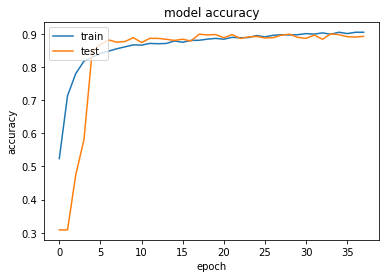

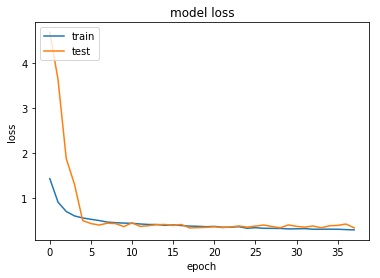

11107/11107 [==============================] - 357s 32ms/sample
train confuse matrix is
[[3957    0    3    0    0    5   12    5]
 [   4  388    1    0    0    5    0    3]
 [  17    0  917    1    0    9    2   10]
 [   3    6    3  568    0   16   10   50]
 [   0    0    2   59    4    4    0   11]
 [   5    0    3   57    0 3350    7    9]
 [   4    0    3    7    0    7  356   35]
 [   8   21   38  225    2   30  100  765]]
val confuse matrix is
[[973   0   8   0   0   1   6   8]
 [  1  96   1   0   0   1   0   2]
 [ 13   0 210   2   0   5   4   6]
 [  2   3   2 135   0   7   3  12]
 [  0   0   0  11   2   1   2   4]
 [  6   0   2  12   0 830   8   0]
 [  1   0   0   4   0   5  75  18]
 [  8   3  12  66   3   5  39 162]]
FOLD:  2
2779 11108
output1 is Tensor("global_max_pooling1d/Max:0", shape=(?, 32), dtype=float32)
output2 is Tensor("global_average_pooling1d/Mean:0", shape=(?, 32), dtype=float32)
output is Tensor("concatenate/concat:0", shape=(?, 64), dtype=float32)
Train on 111

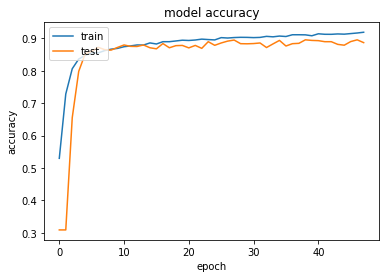

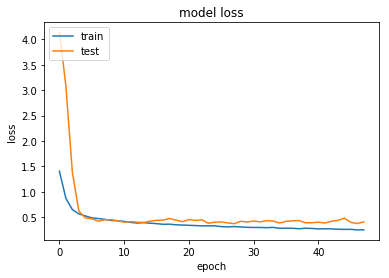

11108/11108 [==============================] - 327s 29ms/sample
train confuse matrix is
[[3972    0    2    0    0    3    0    5]
 [   9  389    0    0    0    3    0    0]
 [  17    0  924    1    0    7    2    6]
 [   2    7    2  598    0   16    3   28]
 [   2    0    1   61    7    3    1    5]
 [  61    0    1   65    0 3276    8   20]
 [   2    0    2    6    0    2  327   73]
 [  23   19   28  225    0   10   27  857]]
val confuse matrix is
[[988   0   2   0   0   1   2   3]
 [  0  97   1   0   0   2   0   1]
 [ 17   0 209   1   0   2   3   7]
 [  5   1   2 124   0   4   2  26]
 [  1   0   1  15   0   1   0   2]
 [ 16   0   1  19   0 807   6   9]
 [  3   0   0   3   0   7  68  22]
 [ 17   5  12  78   0   6  13 167]]
FOLD:  3
2777 11110
output1 is Tensor("global_max_pooling1d/Max:0", shape=(?, 32), dtype=float32)
output2 is Tensor("global_average_pooling1d/Mean:0", shape=(?, 32), dtype=float32)
output is Tensor("concatenate/concat:0", shape=(?, 64), dtype=float32)
Train on 111

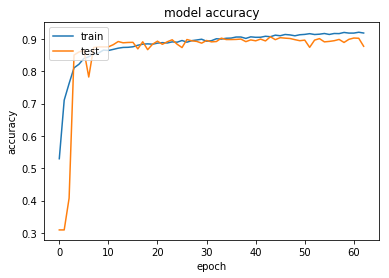

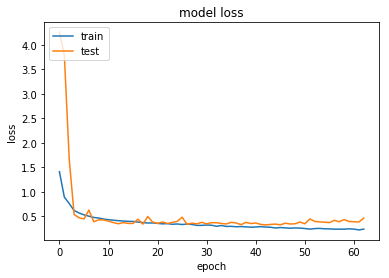

 1589/11110 [===>..........................] - ETA: 5:27Buffered data was truncated after reaching the output size limit.

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 32
kernel_size = 3
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = DPCNN(max_len,max_cnt,embed_size,num_filters,kernel_size,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=64,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=1, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=1, verbose=1)
    pred_train = cpu_model.predict(X_train, batch_size=1, verbose=1)
    
    print('train confuse matrix is')
    print(confusion_matrix(X_train_label.argmax(1), pred_train.argmax(1)))
    print('val confuse matrix is')
    print(confusion_matrix(X_val_label.argmax(1), pred_val.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

In [0]:
import pandas as pd

test_df = pd.DataFrame(meta_test)
test_df.columns = ['prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7']
test_df.index += 1 
test_df.index.name = 'file_id'

test_df.to_csv(os.path.join(data_folder_path, 'secruity_submit_keep_50000_dpcnn.csv'))

FOLD:  1
2780 11107
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Train on 11107 samples, validate on 2780 samples
Epoch 1/100
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
11107/11107 [==============================] - 190s 17ms/sample - loss: 3.1932 - acc: 0.4887 - val_loss: 1.7301 - val_acc: 0.2035
Epoch 2/100
11107/11107 [==============================] - 42s 4ms/sample - loss: 0.9914 - acc: 0.6874 - val_loss: 1.4417 - val_acc: 0.4993
Epoch 3/100
11107/11107 [===========================

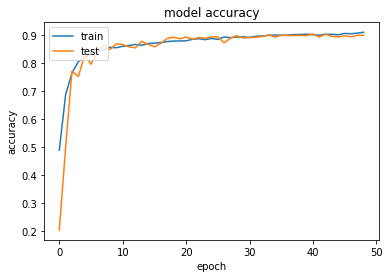

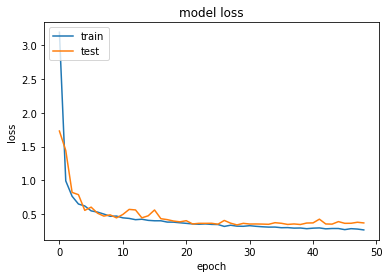

KeyboardInterrupt: ignored

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 32
kernel_size = 3
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = DPCNN(max_len,max_cnt,embed_size,num_filters,kernel_size,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=64,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=1, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=1, verbose=1)
    pred_train = cpu_model.predict(X_train, batch_size=1, verbose=1)
    
    print('train confuse matrix is')
    print(confusion_matrix(X_train_label.argmax(1), pred_train.argmax(1)))
    print('val confuse matrix is')
    print(confusion_matrix(X_val_label.argmax(1), pred_val.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

50000+preprocess+filter num 24

FOLD:  1
2780 11107
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Train on 11107 samples, validate on 2780 samples
Epoch 1/100
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
11107/11107 [==============================] - 124s 11ms/sample - loss: 1.0889 - acc: 0.6331 - val_loss: 0.5780 - val_acc: 0.8181
Epoch 2/100
11107/11107 [==============================] - 55s 5ms/sample - loss: 0.6337 - acc: 0.7975 - val_loss: 0.4823 - val_acc: 0.8483
Epoch 3/100
11107/11107 [===========================

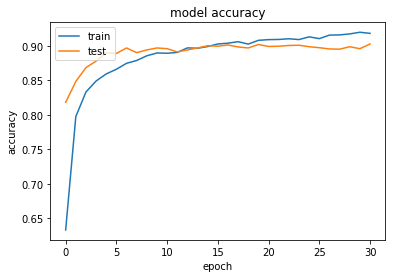

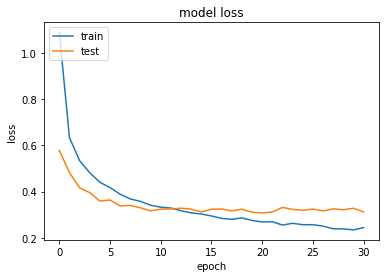

13887/13887 [==============================] - 207s 15ms/sample
[[4943    1    4    1    0   23    0    6]
 [   4  488    0    0    0   10    0    0]
 [  20    0 1139    0    0   12    4   21]
 [   3    9    3  673    0   25    5  102]
 [   0    0    0   68    5    9    3   15]
 [   7    1    2   58    1 4206   13    1]
 [   2    0    0    4    0   10  441   58]
 [  18   24   22  191    0   39   68 1125]]
FOLD:  2
2779 11108
Train on 11108 samples, validate on 2779 samples
Epoch 1/100
11108/11108 [==============================] - 125s 11ms/sample - loss: 1.0985 - acc: 0.6199 - val_loss: 0.6485 - val_acc: 0.7950
Epoch 2/100
11108/11108 [==============================] - 54s 5ms/sample - loss: 0.6143 - acc: 0.8060 - val_loss: 0.4994 - val_acc: 0.8350
Epoch 3/100
11108/11108 [==============================] - 54s 5ms/sample - loss: 0.5090 - acc: 0.8424 - val_loss: 0.4656 - val_acc: 0.8566
Epoch 4/100
11108/11108 [==============================] - 53s 5ms/sample - loss: 0.4456 - acc: 0.86

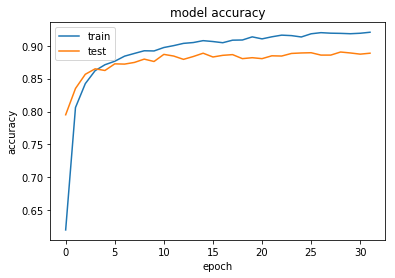

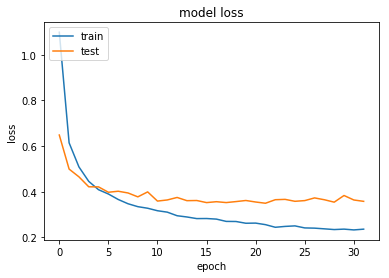

13887/13887 [==============================] - 211s 15ms/sample
[[4936    2    8    0    0   25    0    7]
 [   0  492    0    0    0   10    0    0]
 [  16    1 1160    0    0   11    1    7]
 [   6    9    3  712    0   26    6   58]
 [   2    0    1   68    9    8    2   10]
 [   6    0    2   61    0 4203    8    9]
 [   4    0    3    5    0   18  430   55]
 [  15   24   36  237    0   44   98 1033]]
FOLD:  3
2777 11110
Train on 11110 samples, validate on 2777 samples
Epoch 1/100
11110/11110 [==============================] - 127s 11ms/sample - loss: 1.0871 - acc: 0.6232 - val_loss: 0.5722 - val_acc: 0.8213
Epoch 2/100
11110/11110 [==============================] - 54s 5ms/sample - loss: 0.6343 - acc: 0.7994 - val_loss: 0.4717 - val_acc: 0.8509
Epoch 3/100
11110/11110 [==============================] - 54s 5ms/sample - loss: 0.5262 - acc: 0.8324 - val_loss: 0.4330 - val_acc: 0.8624
Epoch 4/100
11110/11110 [==============================] - 54s 5ms/sample - loss: 0.4700 - acc: 0.84

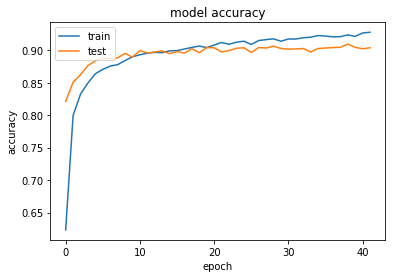

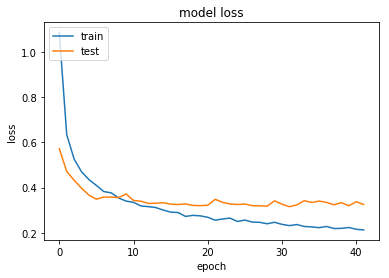

13887/13887 [==============================] - 199s 14ms/sample
[[4940    0   11    0    0   19    2    6]
 [   3  490    0    0    0    9    0    0]
 [   9    0 1169    1    0   10    0    7]
 [   1    9    2  673   12   20   12   91]
 [   2    0    0   47   35    7    1    8]
 [   9    0    1   61    3 4199   10    6]
 [   3    0    4    3    0   11  437   57]
 [  17   24   33  183    7   29   84 1110]]
FOLD:  4
2776 11111
Train on 11111 samples, validate on 2776 samples
Epoch 1/100
11111/11111 [==============================] - 127s 11ms/sample - loss: 1.1025 - acc: 0.6169 - val_loss: 0.6257 - val_acc: 0.8152
Epoch 2/100
11111/11111 [==============================] - 54s 5ms/sample - loss: 0.6480 - acc: 0.7966 - val_loss: 0.5140 - val_acc: 0.8383
Epoch 3/100
11111/11111 [==============================] - 54s 5ms/sample - loss: 0.5246 - acc: 0.8364 - val_loss: 0.4502 - val_acc: 0.8584
Epoch 4/100
11111/11111 [==============================] - 53s 5ms/sample - loss: 0.4623 - acc: 0.85

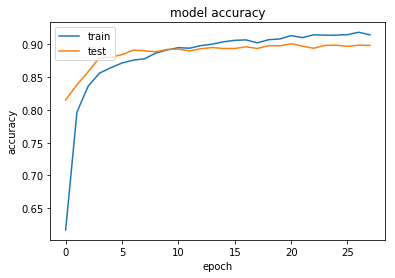

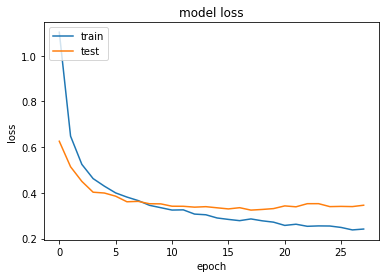

13887/13887 [==============================] - 196s 14ms/sample
[[4948    0    4    0    0   16    0   10]
 [   8  481    0    0    0   12    0    1]
 [  13    0 1159    0    0   12    0   12]
 [   4   10    4  648    0   25    6  123]
 [   1    0    0   69   10    7    1   12]
 [   5    0    5   64    0 4198    3   14]
 [   5    0    3    2    0   23  397   85]
 [  25   26   31  174    0   33   63 1135]]
FOLD:  5
2775 11112
Train on 11112 samples, validate on 2775 samples
Epoch 1/100
11112/11112 [==============================] - 127s 11ms/sample - loss: 1.0877 - acc: 0.6291 - val_loss: 0.5925 - val_acc: 0.8064
Epoch 2/100
11112/11112 [==============================] - 54s 5ms/sample - loss: 0.6272 - acc: 0.8025 - val_loss: 0.4737 - val_acc: 0.8450
Epoch 3/100
11112/11112 [==============================] - 54s 5ms/sample - loss: 0.5150 - acc: 0.8393 - val_loss: 0.4544 - val_acc: 0.8587
Epoch 4/100
11112/11112 [==============================] - 54s 5ms/sample - loss: 0.4586 - acc: 0.85

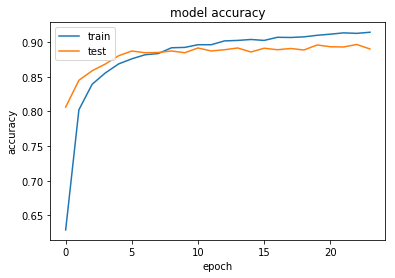

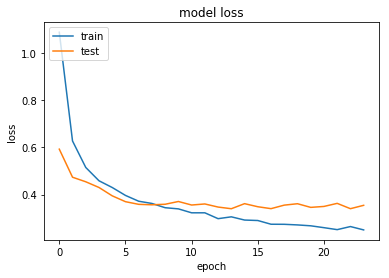

13887/13887 [==============================] - 186s 13ms/sample
[[4954    0    2    1    0   15    3    3]
 [   4  487    0    0    0   11    0    0]
 [  29    0 1135    0    0   19    3   10]
 [   4    9    3  707    2   27   12   56]
 [   4    0    1   58   15   10    3    9]
 [   8    0    2   62    1 4198   10    8]
 [   8    0    3    3    0   23  451   27]
 [  23   24   35  245    3   44  196  917]]


In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 24
kernel_size_short = [2, 4, 6, 8, 10, 12, 14]
kernel_size_long = [36, 40, 44,  48,  52, 56]
kernel_size_short_and_long = kernel_size_long + kernel_size_short
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = TextCNN(max_len,max_cnt,embed_size,num_filters,kernel_size_short,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=64,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=64, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=64, verbose=1)
    
    pred_train = cpu_model.predict(train_seq, batch_size=64, verbose=1)
    print(confusion_matrix(multi_train_labels, pred_train.argmax(1)))
    #print(confusion_matrix(binary_labels.argmax(1), pred_train.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

915


In [0]:
wrong_1000_index = [46,79,178,184,318,331,372,392,403,512,646,686,700,706,726,743,761,801,990,1035,1085,1112,1134,1145,1184,1220,1252,1269,1397,1407,1471,1639,1732,1744,1787,1866,1872,1903,1913,1926,2005,2020,2031,2110,2165,2205,2293,2323,2401,2429,2455,2555,2573,2679,2732,2755,2763,2788,2866,3046,3063,3089,3156,3278,3288,3368,3441,3475,3577,3592,3607,3620,3629,3631,3633,3799,3810,3860,3913,3954,3997,4000,4029,4084,4196,4218,4224,4244,4311,4312,4321,4322,4330,4394,4446,4461,4528,4543,4581,4590,4608,4635,4737,4738,4791,4803,4839,4866,4920,4933,4990,5065,5088,5097,5212,5294,5419,5570,5574,5670,5715,5745,5772,5852,5854,5864,5930,5965,5983,6052,6057,6093,6135,6162,6214,6215,6295,6355,6444,6535,6564,6580,6627,6842,6858,6964,7000,7017,7074,7080,7102,7105,7172,7249,7297,7582,7649,7662,7842,7871,7879,7886,7925,7964,7992,8021,8093,8136,8277,8280,8296,8361,8365,8437,8456,8516,8527,8556,8579,8598,8628,8636,8710,8713,8721,8738,8766,8774,8779,8780,8842,8844,8974,8982,8998,9039,9049,9068,9132,9144,9179,9198,9299,9339,9367,9387,9402,9466,9471,9496,9551,9631,9659,9680,9712,9741,9777,9839,9843,9900,9984,10048,10095,10110,10127,10165,10167,10178,10190,10217,10287,10292,10295,10310,10381,10422,10444,10541,10542,10651,10683,10720,10723,10731,10790,10874,10900,10911,10931,10961,11001,11189,11190,11277,11493,11517,11566,11604,11629,11642,11666,11668,11736,11796,11815,11918,11961,11962,11989,12000,12210,12258,12269,12290,12445,12541,12653,12677,12706,12712,12796,12867,12882,12909,12934,13023,13095,13113,13162,13193,13210,13236,13288,13336,13360,13371,13414,13489,13493,13528,13546,13570,13642,13725,13866]

In [0]:
print(np.sum(real[wrong_1000_index] == 0))
print(np.sum(real[wrong_1000_index] == 1))
print(np.sum(real[wrong_1000_index] == 2))
print(np.sum(real[wrong_1000_index] == 3))
print(np.sum(real[wrong_1000_index] == 4))
print(np.sum(real[wrong_1000_index] == 5))
print(np.sum(real[wrong_1000_index] == 6))
print(np.sum(real[wrong_1000_index] == 7))

28
10
19
63
21
20
15
129


In [0]:
#wrong_1000_index
wrong_1000_index[real[wrong_1000_index] == 7]

TypeError: ignored

In [0]:
from collections import Counter

print(wrong_1000_index)
print('real is')
print(real[wrong_1000_index])
print('predict is:')
print(pred[wrong_1000_index])
print(pred[wrong_1000_index][real[wrong_1000_index] == 7])
Counter(pred[wrong_1000_index][real[wrong_1000_index] == 7])

[46, 79, 178, 184, 318, 331, 372, 392, 403, 512, 646, 686, 700, 706, 726, 743, 761, 801, 990, 1035, 1085, 1112, 1134, 1145, 1184, 1220, 1252, 1269, 1397, 1407, 1471, 1639, 1732, 1744, 1787, 1866, 1872, 1903, 1913, 1926, 2005, 2020, 2031, 2110, 2165, 2205, 2293, 2323, 2401, 2429, 2455, 2555, 2573, 2679, 2732, 2755, 2763, 2788, 2866, 3046, 3063, 3089, 3156, 3278, 3288, 3368, 3441, 3475, 3577, 3592, 3607, 3620, 3629, 3631, 3633, 3799, 3810, 3860, 3913, 3954, 3997, 4000, 4029, 4084, 4196, 4218, 4224, 4244, 4311, 4312, 4321, 4322, 4330, 4394, 4446, 4461, 4528, 4543, 4581, 4590, 4608, 4635, 4737, 4738, 4791, 4803, 4839, 4866, 4920, 4933, 4990, 5065, 5088, 5097, 5212, 5294, 5419, 5570, 5574, 5670, 5715, 5745, 5772, 5852, 5854, 5864, 5930, 5965, 5983, 6052, 6057, 6093, 6135, 6162, 6214, 6215, 6295, 6355, 6444, 6535, 6564, 6580, 6627, 6842, 6858, 6964, 7000, 7017, 7074, 7080, 7102, 7105, 7172, 7249, 7297, 7582, 7649, 7662, 7842, 7871, 7879, 7886, 7925, 7964, 7992, 8021, 8093, 8136, 8277, 8280, 

Counter({0: 9, 1: 13, 2: 18, 3: 21, 5: 21, 6: 47})

In [0]:
"real_1000_data_c7 = np.argwhere(real[wrong_1000_index] == 7)
print(real_1000_data_c7)

[[  1]
 [  3]
 [  5]
 [  6]
 [ 11]
 [ 14]
 [ 15]
 [ 18]
 [ 19]
 [ 22]
 [ 23]
 [ 28]
 [ 30]
 [ 31]
 [ 32]
 [ 33]
 [ 36]
 [ 37]
 [ 38]
 [ 44]
 [ 45]
 [ 48]
 [ 50]
 [ 51]
 [ 57]
 [ 58]
 [ 59]
 [ 60]
 [ 62]
 [ 67]
 [ 68]
 [ 70]
 [ 79]
 [ 81]
 [ 83]
 [ 85]
 [ 87]
 [ 88]
 [ 90]
 [ 96]
 [ 97]
 [ 98]
 [105]
 [106]
 [107]
 [108]
 [109]
 [114]
 [117]
 [118]
 [119]
 [126]
 [127]
 [128]
 [130]
 [134]
 [135]
 [138]
 [139]
 [141]
 [144]
 [145]
 [148]
 [149]
 [150]
 [151]
 [152]
 [153]
 [156]
 [158]
 [159]
 [161]
 [162]
 [168]
 [171]
 [178]
 [181]
 [184]
 [189]
 [191]
 [193]
 [194]
 [200]
 [202]
 [203]
 [205]
 [211]
 [212]
 [214]
 [220]
 [221]
 [228]
 [229]
 [232]
 [234]
 [235]
 [238]
 [239]
 [240]
 [241]
 [244]
 [245]
 [248]
 [249]
 [250]
 [255]
 [258]
 [261]
 [262]
 [263]
 [265]
 [267]
 [272]
 [274]
 [277]
 [281]
 [282]
 [283]
 [285]
 [286]
 [287]
 [289]
 [291]
 [299]
 [300]
 [301]
 [302]
 [303]
 [304]]


In [0]:
np.sum(real[wrong_1000_index] == 7)

39

In [0]:
pred = np.argmax(pred_train, axis = 1)

array([1, 5, 0, 0, 5, 7, 0, 2, 0, 6, 7, 7, 0, 2, 7, 0, 2, 0, 0, 3, 5, 7,
       0, 3, 0, 0, 5, 2, 0, 0, 5, 2, 5, 0, 5, 0, 0, 0, 0, 3, 7, 0, 0, 7,
       5, 5, 3, 5, 7, 0, 5, 5, 5, 5, 0, 0, 5, 0, 3, 1, 7, 0, 0, 0, 2, 3,
       0, 5, 5, 0, 0, 0, 5, 1, 5, 5, 0, 5, 3, 3, 2, 0, 7, 0, 6, 3, 6, 0,
       7, 0, 2, 2, 5, 3, 2, 5, 6, 5, 6, 5, 6, 3, 7, 5, 0, 0, 5, 0, 5, 7,
       0, 5, 6, 5, 5, 0, 0, 5, 7, 0, 5, 2, 5, 0, 5, 5, 3, 0, 2, 0, 6, 5,
       5, 2, 2, 5, 0, 0, 5, 7, 5, 5, 7, 0, 7, 2, 5, 0, 3, 0, 2, 5, 5, 7,
       5, 5, 3, 5, 6, 1, 0, 7, 6, 7, 0, 3, 2, 0, 0, 0, 0, 1, 7, 5, 3, 5,
       5, 5, 5, 7, 5, 0, 0, 7, 2, 5, 0, 0, 5, 0, 1, 5, 0, 2, 7, 2, 5, 2,
       0, 5, 0, 7, 7, 0, 5, 5, 5, 3, 0, 7, 0, 3, 5, 7, 5, 5, 0, 5, 5, 2,
       0, 0, 5, 5, 0, 5, 7, 6, 0, 2, 0, 0, 5, 0, 3, 2, 5, 1, 5, 5, 5, 0,
       5, 3, 2, 5, 5, 0, 5, 5, 0, 2, 0, 5, 0, 5, 7, 0, 1, 3, 7, 0, 0, 5,
       0, 5, 3, 0, 0, 3, 5, 0, 0, 5, 0, 7, 5, 0, 5, 5, 2, 0, 3, 0, 5, 0,
       0, 0, 7, 0, 0, 0, 2, 5, 0, 0, 5, 5, 5, 5, 0,

In [0]:
np.argmax(pred_train[14])

3

In [0]:
np.argmax(train_labels[14])

7

In [0]:
pred = np.argmax(pred_train, axis = 1)
real = np.argmax(train_labels, axis = 1)
not_same = np.argwhere(pred != real)

print(not_same)

[[   14]
 [   26]
 [   38]
 [   46]
 [   51]
 [   60]
 [   79]
 [  105]
 [  106]
 [  113]
 [  124]
 [  139]
 [  142]
 [  143]
 [  178]
 [  184]
 [  187]
 [  229]
 [  231]
 [  287]
 [  311]
 [  318]
 [  331]
 [  357]
 [  370]
 [  372]
 [  392]
 [  403]
 [  405]
 [  421]
 [  431]
 [  462]
 [  478]
 [  480]
 [  512]
 [  530]
 [  559]
 [  562]
 [  612]
 [  622]
 [  646]
 [  686]
 [  700]
 [  706]
 [  726]
 [  743]
 [  757]
 [  761]
 [  766]
 [  770]
 [  795]
 [  801]
 [  803]
 [  834]
 [  839]
 [  923]
 [  942]
 [  978]
 [  990]
 [ 1035]
 [ 1036]
 [ 1071]
 [ 1085]
 [ 1112]
 [ 1134]
 [ 1144]
 [ 1145]
 [ 1166]
 [ 1184]
 [ 1186]
 [ 1201]
 [ 1220]
 [ 1224]
 [ 1252]
 [ 1263]
 [ 1269]
 [ 1307]
 [ 1315]
 [ 1355]
 [ 1374]
 [ 1389]
 [ 1397]
 [ 1405]
 [ 1407]
 [ 1425]
 [ 1449]
 [ 1453]
 [ 1471]
 [ 1476]
 [ 1486]
 [ 1526]
 [ 1528]
 [ 1530]
 [ 1539]
 [ 1549]
 [ 1571]
 [ 1575]
 [ 1581]
 [ 1589]
 [ 1614]
 [ 1635]
 [ 1639]
 [ 1724]
 [ 1732]
 [ 1744]
 [ 1780]
 [ 1787]
 [ 1791]
 [ 1816]
 [ 1820]
 [ 1823]
 

50000+preprocess+filter num 24 new seq

FOLD:  1
2780 11107
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
warppers is []

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Train on 11107 samples, validate on 2780 samples
Epoch 1/100
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
11107/11107 [==============================] - 115s 10ms/sample - loss: 1.0888 - acc: 0.6337 - val_loss: 0.5428 - val_acc: 0.8365
Epoch 2/100
11107/11107 [==============================] - 54s 5ms/sample - loss: 0.6047 - acc: 0.8137 - val_loss: 0.4182 - val_acc: 0.8635
Epoch 3/100
11107/11107 [============

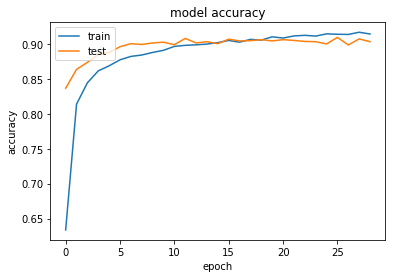

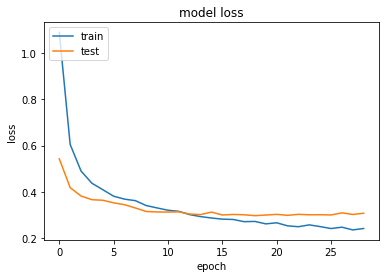

13887/13887 [==============================] - 209s 15ms/sample
[[4952    0   11    0    0    8    1    6]
 [   5  492    0    0    0    5    0    0]
 [  17    0 1163    0    0   12    1    3]
 [   4    9    8  650   17   27   13   92]
 [   2    0    3   49   31    7    1    7]
 [   8    0    3   51    1 4214   11    1]
 [   3    0    3    3    0   15  450   41]
 [  27   23   56  187   22   56  124  992]]
FOLD:  2
2779 11108
warppers is []
Train on 11108 samples, validate on 2779 samples
Epoch 1/100
11108/11108 [==============================] - 117s 11ms/sample - loss: 1.0626 - acc: 0.6370 - val_loss: 0.5857 - val_acc: 0.8166
Epoch 2/100
11108/11108 [==============================] - 54s 5ms/sample - loss: 0.5911 - acc: 0.8187 - val_loss: 0.4550 - val_acc: 0.8552
Epoch 3/100
11108/11108 [==============================] - 54s 5ms/sample - loss: 0.4841 - acc: 0.8482 - val_loss: 0.4277 - val_acc: 0.8606
Epoch 4/100
11108/11108 [==============================] - 54s 5ms/sample - loss: 0.4

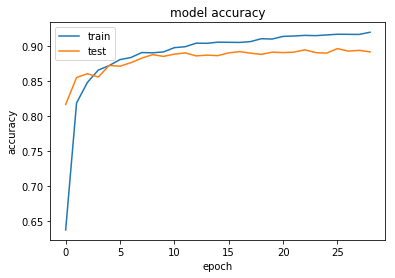

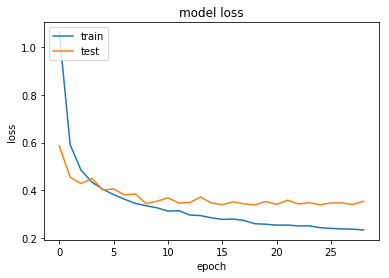

13887/13887 [==============================] - 201s 14ms/sample
[[4945    2   11    0    0    9    0   11]
 [   3  490    3    0    0    5    0    1]
 [  17    0 1171    0    0    7    1    0]
 [   8   10    7  617   10   28    6  134]
 [   2    0    5   45   27    9    2   10]
 [  16    0    7   61    0 4195    6    4]
 [   1    0    6    1    0   15  371  121]
 [  19   24   70  159   22   46   53 1094]]
FOLD:  3
2777 11110
warppers is []
Train on 11110 samples, validate on 2777 samples
Epoch 1/100
11110/11110 [==============================] - 122s 11ms/sample - loss: 1.0627 - acc: 0.6436 - val_loss: 0.5522 - val_acc: 0.8228
Epoch 2/100
11110/11110 [==============================] - 54s 5ms/sample - loss: 0.5949 - acc: 0.8119 - val_loss: 0.4191 - val_acc: 0.8624
Epoch 3/100
11110/11110 [==============================] - 54s 5ms/sample - loss: 0.4944 - acc: 0.8463 - val_loss: 0.3855 - val_acc: 0.8671
Epoch 4/100
11110/11110 [==============================] - 54s 5ms/sample - loss: 0.4

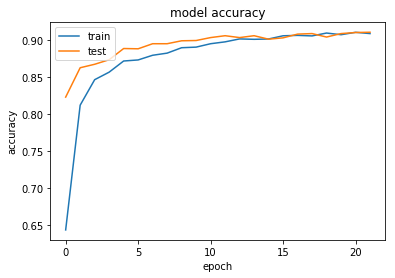

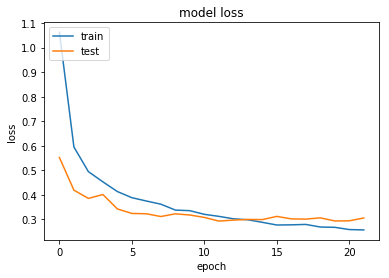

13887/13887 [==============================] - 187s 13ms/sample
[[4955    0    9    0    0    6    1    7]
 [  12  485    0    0    0    5    0    0]
 [  19    0 1160    0    0    9    2    6]
 [   3    9    5  689    0   25    5   84]
 [   4    0    2   74    0    9    1   10]
 [  14    0    5   69    0 4194    4    3]
 [   3    0    4    6    0   23  409   70]
 [  35   24   52  225    0   45   92 1014]]
FOLD:  4
2776 11111
warppers is []
Train on 11111 samples, validate on 2776 samples
Epoch 1/100
11111/11111 [==============================] - 124s 11ms/sample - loss: 1.0600 - acc: 0.6399 - val_loss: 0.5966 - val_acc: 0.8008
Epoch 2/100
11111/11111 [==============================] - 54s 5ms/sample - loss: 0.5911 - acc: 0.8165 - val_loss: 0.5098 - val_acc: 0.8462
Epoch 3/100
11111/11111 [==============================] - 54s 5ms/sample - loss: 0.4921 - acc: 0.8433 - val_loss: 0.4340 - val_acc: 0.8653
Epoch 4/100
11111/11111 [==============================] - 53s 5ms/sample - loss: 0.4

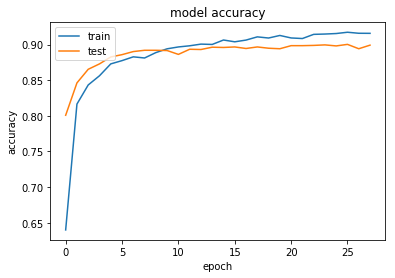

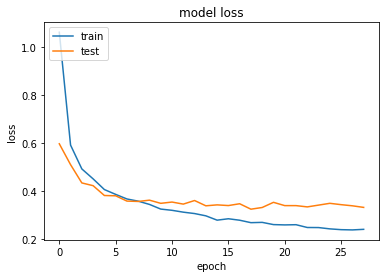

13887/13887 [==============================] - 208s 15ms/sample
[[4948    0    5    0    0   11    1   13]
 [  11  484    1    0    0    6    0    0]
 [  19    0 1150    0    0   11    1   15]
 [   4    9    4  611    2   24    4  162]
 [   1    0    0   64   10    6    3   16]
 [   6    0    6   65    0 4195    6   11]
 [   3    0    2    1    0   16  403   90]
 [  17   24   27  136    1   38   67 1177]]
FOLD:  5
2775 11112
warppers is []
Train on 11112 samples, validate on 2775 samples
Epoch 1/100
11112/11112 [==============================] - 124s 11ms/sample - loss: 1.0783 - acc: 0.6362 - val_loss: 0.5619 - val_acc: 0.8248
Epoch 2/100
11112/11112 [==============================] - 54s 5ms/sample - loss: 0.5930 - acc: 0.8143 - val_loss: 0.4528 - val_acc: 0.8551
Epoch 3/100
11112/11112 [==============================] - 54s 5ms/sample - loss: 0.4974 - acc: 0.8458 - val_loss: 0.4387 - val_acc: 0.8573
Epoch 4/100
11112/11112 [==============================] - 54s 5ms/sample - loss: 0.4

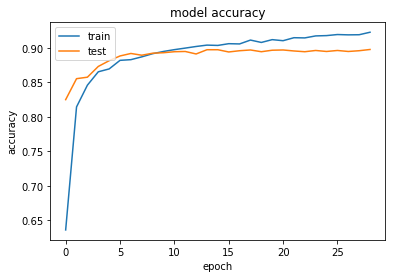

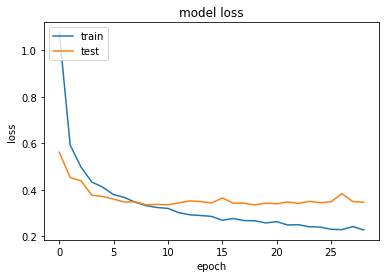

13887/13887 [==============================] - 184s 13ms/sample
[[4957    0    7    0    0    7    0    7]
 [   5  492    0    0    0    5    0    0]
 [  14    0 1154    0    0   18    0   10]
 [   4    9    5  640    2   31    4  125]
 [   3    0    1   46   13   11    2   24]
 [  11    0    1   55    0 4208    6    8]
 [   6    0    2    3    0   22  389   93]
 [  18   24   33  159    2   48   59 1144]]


In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 24
kernel_size_short = [2, 4, 6, 8, 10, 12, 14]
kernel_size_long = [36, 40, 44,  48,  52, 56]
kernel_size_short_and_long = kernel_size_long + kernel_size_short
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = TextCNN(max_len,max_cnt,embed_size,num_filters,kernel_size_short,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=64,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=64, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=64, verbose=1)
    
    pred_train = cpu_model.predict(train_seq, batch_size=64, verbose=1)
    print(confusion_matrix(multi_train_labels, pred_train.argmax(1)))
    #print(confusion_matrix(binary_labels.argmax(1), pred_train.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

In [0]:
import pandas as pd

test_df = pd.DataFrame(meta_test)
test_df.columns = ['prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7']
test_df.index += 1 
test_df.index.name = 'file_id'

test_df.to_csv(os.path.join(data_folder_path, 'secruity_submit_preprocess_50000_filter_num_24_keep_all_element.csv'))

50000+preprocess+filter num 24 new seq kmaxpooling
speed is too slow, have to give up

FOLD:  1
2780 11107
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Train on 11107 samples, validate on 2780 samples
Epoch 1/100
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
11107/11107 [==============================] - 549s 49ms/sample - loss: 1.0849 - acc: 0.6396 - val_loss: 0.5359 - val_acc: 0.8372
Epoch 2/100
11107/11107 [==============================] - 421s 38ms/sample - loss: 0.5861 - acc: 0.8201 - val_loss: 0.4200 - val_acc: 0.8635
Epoch 3/100
11107/11107 [==============================] - 421s 38ms/sample - loss: 0.4789 - acc: 0.8478 - val_loss: 0.3830 - va

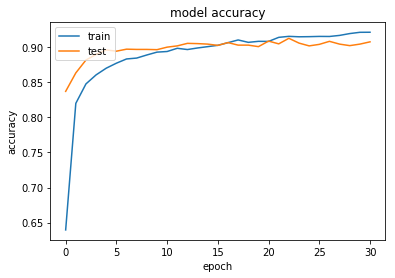

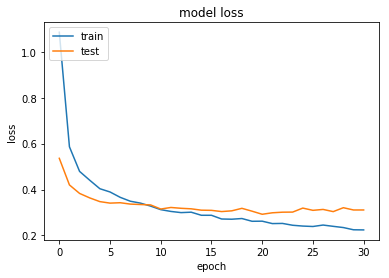

13887/13887 [==============================] - 212s 15ms/sample
[[4955    0    5    1    0   10    0    7]
 [   5  492    0    0    0    5    0    0]
 [  19    0 1144    0    0   18    2   13]
 [   4    9    3  615    3   24    5  157]
 [   0    0    0   31   12    5    2   50]
 [  11    0    2   57    1 4200    6   12]
 [   6    0    0    2    0   14  369  124]
 [  21   25   24  103    1   29   42 1242]]
FOLD:  2
2779 11108
Train on 11108 samples, validate on 2779 samples
Epoch 1/100
11108/11108 [==============================] - 550s 49ms/sample - loss: 1.0550 - acc: 0.6444 - val_loss: 0.5619 - val_acc: 0.8300
Epoch 2/100
11108/11108 [==============================] - 421s 38ms/sample - loss: 0.5785 - acc: 0.8174 - val_loss: 0.4751 - val_acc: 0.8469
Epoch 3/100
11108/11108 [==============================] - 421s 38ms/sample - loss: 0.4845 - acc: 0.8483 - val_loss: 0.4222 - val_acc: 0.8678
Epoch 4/100
11108/11108 [==============================] - 420s 38ms/sample - loss: 0.4356 - acc

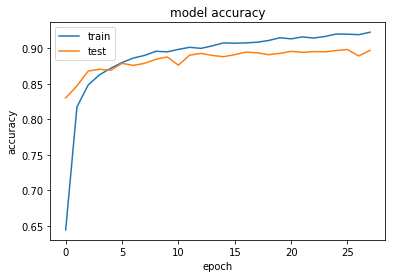

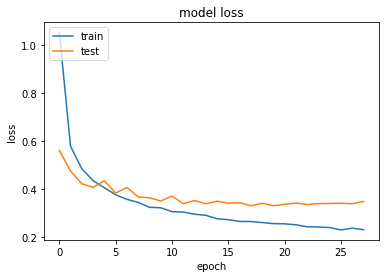

13887/13887 [==============================] - 212s 15ms/sample
[[4952    0   10    0    0   10    0    6]
 [   4  491    1    0    0    5    1    0]
 [  17    0 1162    0    0   10    1    6]
 [   7    9    7  689    0   25   10   73]
 [   1    0    1   69    7   11    2    9]
 [   7    0    3   62    0 4205    9    3]
 [   3    0    3    5    0   16  447   41]
 [  22   24   50  226    1   44  128  992]]
FOLD:  3
2777 11110
Train on 11110 samples, validate on 2777 samples
Epoch 1/100
11110/11110 [==============================] - 554s 50ms/sample - loss: 1.1033 - acc: 0.6303 - val_loss: 0.5367 - val_acc: 0.8419
Epoch 2/100
 4032/11110 [=========>....................] - ETA: 3:38 - loss: 0.6518 - acc: 0.7981

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 24
kernel_size_short = [2, 4, 6, 8, 10, 12, 14]
kernel_size_long = [36, 40, 44,  48,  52, 56]
kernel_size_short_and_long = kernel_size_long + kernel_size_short
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = TextCNN_2(max_len,max_cnt,embed_size,num_filters, kernel_size_short,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=64,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=64, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=64, verbose=1)
    
    pred_train = cpu_model.predict(train_seq, batch_size=64, verbose=1)
    print(confusion_matrix(multi_train_labels, pred_train.argmax(1)))
    #print(confusion_matrix(binary_labels.argmax(1), pred_train.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

In [0]:
import pandas as pd

test_df = pd.DataFrame(meta_test)
test_df.columns = ['prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7']
test_df.index += 1 
test_df.index.name = 'file_id'

test_df.to_csv(os.path.join(data_folder_path, 'secruity_submit_preprocess_50000_filter_num_24_keep_all_element_kmaxpooling.csv'))

50000+preprocess+filter num 24 new seq+add two filter_size

FOLD:  1
2780 11107
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
warppers is []

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Train on 11107 samples, validate on 2780 samples
Epoch 1/100
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
11107/11107 [==============================] - 142s 13ms/sample - loss: 1.0248 - acc: 0.6504 - val_loss: 0.5221 - val_acc: 0.8303
Epoch 2/100
11107/11107 [==============================] - 63s 6ms/sample - loss: 0.5620 - acc: 0.8209 - val_loss: 0.4381 - val_acc: 0.8674
Epoch 3/100
11107/11107 [============

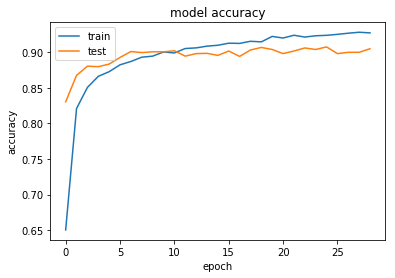

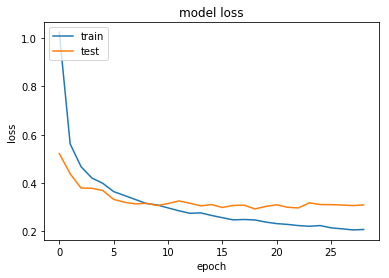

13887/13887 [==============================] - 291s 21ms/sample
[[4949    1    6    0    0    8    0   14]
 [   5  492    0    0    0    5    0    0]
 [  14    0 1161    0    0    8    0   13]
 [   3    9    2  669    5   24   10   98]
 [   1    0    0   49   26    5    1   18]
 [   9    0    6   49    1 4202    4   18]
 [   5    0    2    4    0   11  438   55]
 [  12   24   30  132    3   29   82 1175]]
FOLD:  2
2779 11108
warppers is []
Train on 11108 samples, validate on 2779 samples
Epoch 1/100
11108/11108 [==============================] - 147s 13ms/sample - loss: 0.9868 - acc: 0.6707 - val_loss: 0.5584 - val_acc: 0.8192
Epoch 2/100
11108/11108 [==============================] - 65s 6ms/sample - loss: 0.5571 - acc: 0.8301 - val_loss: 0.4463 - val_acc: 0.8570
Epoch 3/100
11108/11108 [==============================] - 64s 6ms/sample - loss: 0.4670 - acc: 0.8548 - val_loss: 0.4523 - val_acc: 0.8584
Epoch 4/100
11108/11108 [==============================] - 64s 6ms/sample - loss: 0.4

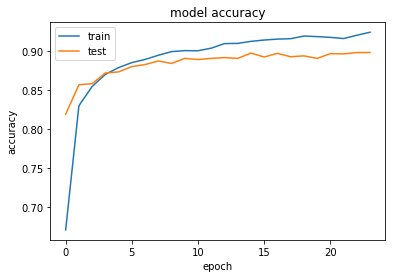

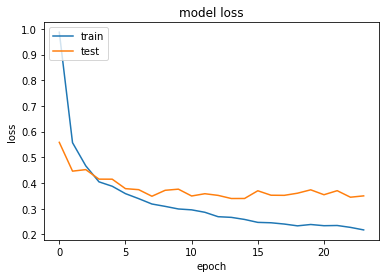

13887/13887 [==============================] - 292s 21ms/sample
[[4960    2    5    0    0    5    1    5]
 [   6  490    1    0    0    5    0    0]
 [  17    0 1168    0    0    7    1    3]
 [   7    8    3  705    0   20    4   73]
 [   2    0    1   67   16    4    2    8]
 [  14    0    9   69    0 4170   16   11]
 [   6    0    3    3    1   10  431   61]
 [  21   24   48  237    4   26   78 1049]]
FOLD:  3
2777 11110
warppers is []
Train on 11110 samples, validate on 2777 samples
Epoch 1/100
11110/11110 [==============================] - 148s 13ms/sample - loss: 1.0125 - acc: 0.6579 - val_loss: 0.5125 - val_acc: 0.8422
Epoch 2/100
11110/11110 [==============================] - 63s 6ms/sample - loss: 0.5705 - acc: 0.8266 - val_loss: 0.4202 - val_acc: 0.8678
Epoch 3/100
11110/11110 [==============================] - 64s 6ms/sample - loss: 0.4801 - acc: 0.8536 - val_loss: 0.3807 - val_acc: 0.8793
Epoch 4/100
11110/11110 [==============================] - 63s 6ms/sample - loss: 0.4

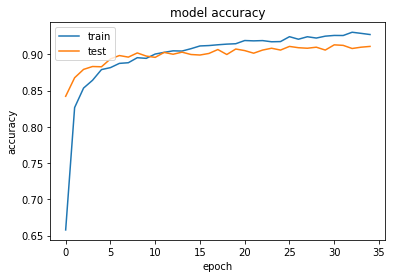

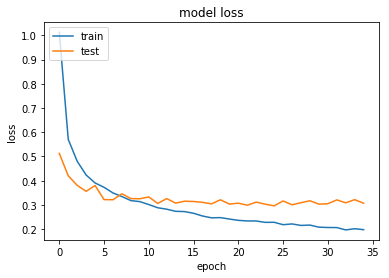

13887/13887 [==============================] - 300s 22ms/sample
[[4959    0    8    1    0    6    0    4]
 [   4  493    0    0    0    5    0    0]
 [  15    0 1169    0    0    9    0    3]
 [   2    9    2  604    7   21    6  169]
 [   1    0    0   32   41    4    2   20]
 [  10    0    1   48    0 4202    8   20]
 [   4    0    2    2    0    6  429   72]
 [  26   24   28  106    3   17   29 1254]]
FOLD:  4
2776 11111
warppers is []
Train on 11111 samples, validate on 2776 samples
Epoch 1/100
11111/11111 [==============================] - 151s 14ms/sample - loss: 0.9912 - acc: 0.6702 - val_loss: 0.5724 - val_acc: 0.8238
Epoch 2/100
11111/11111 [==============================] - 63s 6ms/sample - loss: 0.5405 - acc: 0.8347 - val_loss: 0.4843 - val_acc: 0.8509
Epoch 3/100
11111/11111 [==============================] - 63s 6ms/sample - loss: 0.4487 - acc: 0.8578 - val_loss: 0.4577 - val_acc: 0.8671
Epoch 4/100
11111/11111 [==============================] - 63s 6ms/sample - loss: 0.4

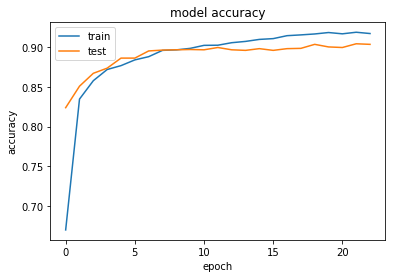

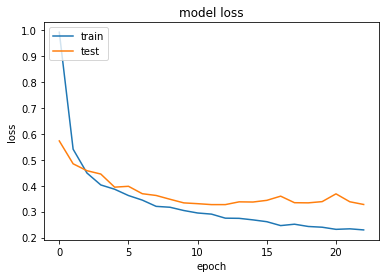

13887/13887 [==============================] - 304s 22ms/sample
[[4947    0    7    0    0   13    1   10]
 [  12  482    0    0    0    6    0    2]
 [  18    0 1148    2    0   14    0   14]
 [   2    9    4  653    0   26    3  123]
 [   1    0    0   69   11    9    2    8]
 [   7    0    0   57    0 4218    2    5]
 [   4    0    4    6    0   15  404   82]
 [  20   24   21  180    0   43   61 1138]]
FOLD:  5
2775 11112
warppers is []
Train on 11112 samples, validate on 2775 samples
Epoch 1/100
11112/11112 [==============================] - 151s 14ms/sample - loss: 1.0271 - acc: 0.6533 - val_loss: 0.5588 - val_acc: 0.8291
Epoch 2/100
11112/11112 [==============================] - 63s 6ms/sample - loss: 0.5653 - acc: 0.8202 - val_loss: 0.4655 - val_acc: 0.8475
Epoch 3/100
11112/11112 [==============================] - 64s 6ms/sample - loss: 0.4625 - acc: 0.8568 - val_loss: 0.3807 - val_acc: 0.8725
Epoch 4/100
11112/11112 [==============================] - 64s 6ms/sample - loss: 0.4

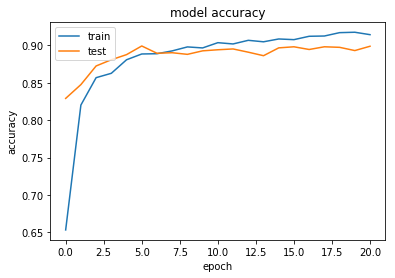

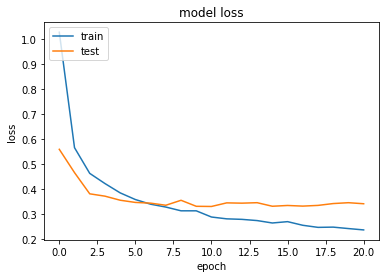

13887/13887 [==============================] - 299s 21ms/sample
[[4951    1    6    1    0    8    2    9]
 [   7  490    0    0    0    5    0    0]
 [  15    0 1157    0    0   10    2   12]
 [   3    9    3  662    0   23    6  114]
 [   4    0    2   54    5    8    1   26]
 [   9    0    7   65    0 4180   15   13]
 [   5    0    2    2    0    8  411   87]
 [  15   24   31  183    0   30   71 1133]]


In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 24
kernel_size_short = [2, 4, 6, 8, 10, 12, 14] + [16, 18]
kernel_size_long = [36, 40, 44,  48,  52, 56]
kernel_size_short_and_long = kernel_size_long + kernel_size_short
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = TextCNN(max_len,max_cnt,embed_size,num_filters,kernel_size_short,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=64,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=64, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=64, verbose=1)
    
    pred_train = cpu_model.predict(train_seq, batch_size=64, verbose=1)
    print(confusion_matrix(multi_train_labels, pred_train.argmax(1)))
    #print(confusion_matrix(binary_labels.argmax(1), pred_train.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

In [0]:
#loss: 0.2570 - acc: 0.9085 - val_loss: 0.3057 - val_acc: 0.9103
import pandas as pd

test_df = pd.DataFrame(meta_test)
test_df.columns = ['prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7']
test_df.index += 1 
test_df.index.name = 'file_id'

test_df.to_csv(os.path.join(data_folder_path, 'secruity_submit_preprocess_50000_filter_num_24_keep_all_element_add_filter_size.csv'))

空洞卷积（可尝试）

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 24
kernel_size_short = [2, 4, 6, 8, 10, 12, 14]
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = TextCNN_3(max_len,max_cnt,embed_size,num_filters,kernel_size_short,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=64,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=64, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=64, verbose=1)
    
    pred_train = cpu_model.predict(train_seq, batch_size=64, verbose=1)
    print(confusion_matrix(multi_train_labels, pred_train.argmax(1)))
    #print(confusion_matrix(binary_labels.argmax(1), pred_train.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

FOLD:  1
2780 11107
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
warppers is []

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Train on 11107 samples, validate on 2780 samples
Epoch 1/100
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
11107/11107 [==============================] - 318s 29ms/sample - loss: 0.9434 - acc: 0.6843 - val_loss: 0.4928 - val_acc: 0.8332
Epoch 2/100
11107/11107 [==============================] - 130s 12ms/sample - loss: 0.5187 - acc: 0.8347 - val_loss: 0.4586 - val_acc: 0.8660
Epoch 3/100
11107/11107 [==========

KeyboardInterrupt: ignored

In [0]:
#loss: 1.0889 - acc: 0.6331 - val_loss: 0.5780 - val_acc: 0.8181
#loss: 0.6330 - acc: 0.8044 - val_loss: 0.4525 - val_acc: 0.8653
#loss: 0.5260 - acc: 0.8329 - val_loss: 0.4085 - val_acc: 0.8710

#loss: 0.2444 - acc: 0.9181 - val_loss: 0.3120 - val_acc: 0.9027

混合meanpooling和maxpooling

In [0]:
def TextCNN_add_pool(max_len, max_cnt, embed_size,
            num_filters, kernel_size,
            conv_action,
            mask_zero):
    _input = Input(shape=(max_len,), dtype='int32')
    _embed = Embedding(max_cnt, embed_size, input_length=max_len, mask_zero=mask_zero)(_input)
    _embed = SpatialDropout1D(0.15)(_embed)
    warppers = []
    print('warppers is', warppers)
    
    for _kernel_size in kernel_size:
        conv1d = Conv1D(filters=num_filters, kernel_size=_kernel_size, activation=conv_action)(_embed)
        warppers.append(GlobalMaxPooling1D()(conv1d))
        warppers.append(GlobalAveragePooling1D()(conv1d))
                        
    fc = concatenate(warppers)
    fc = Dropout(0.5)(fc)
    #fc = BatchNormalization()(fc)
    fc = Dense(256, activation='relu')(fc)
    fc = Dropout(0.25)(fc)
    #fc = BatchNormalization()(fc) 
    preds = Dense(8, activation = 'softmax')(fc)
    
    model = Model(inputs=_input, outputs=preds)
    
    return model

FOLD:  1
2780 11107
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
warppers is []

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Train on 11107 samples, validate on 2780 samples
Epoch 1/100
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
11107/11107 [==============================] - 120s 11ms/sample - loss: 1.1049 - acc: 0.6216 - val_loss: 0.5659 - val_acc: 0.8343
Epoch 2/100
11107/11107 [==============================] - 55s 5ms/sample - loss: 0.5923 - acc: 0.8093 - val_loss: 0.4255 - val_acc: 0.8628
Epoch 3/100
11107/11107 [============

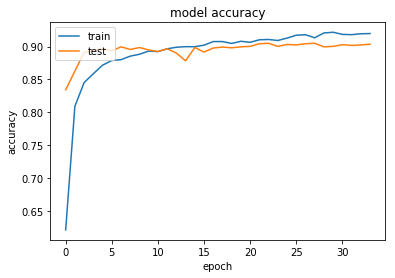

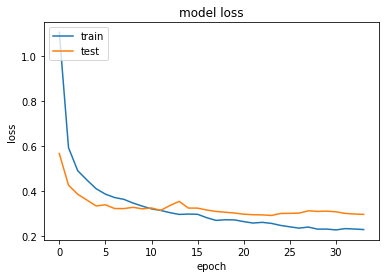

13887/13887 [==============================] - 202s 15ms/sample
[[4947    0    7    0    0    9    0   15]
 [   4  489    0    0    0    9    0    0]
 [  16    0 1157    0    0   12    1   10]
 [   5    9    4  633   12   25    8  124]
 [   0    0    0   32   44    6    6   12]
 [   8    0    4   63    1 4199    7    7]
 [   3    0    1    4    0   18  444   45]
 [  15   24   27  154   15   40   94 1118]]
FOLD:  2
2779 11108
warppers is []
Train on 11108 samples, validate on 2779 samples
Epoch 1/100
11108/11108 [==============================] - 124s 11ms/sample - loss: 1.0537 - acc: 0.6445 - val_loss: 0.5759 - val_acc: 0.8264
Epoch 2/100
11108/11108 [==============================] - 55s 5ms/sample - loss: 0.5914 - acc: 0.8166 - val_loss: 0.4583 - val_acc: 0.8581
Epoch 3/100
11108/11108 [==============================] - 54s 5ms/sample - loss: 0.4769 - acc: 0.8528 - val_loss: 0.4360 - val_acc: 0.8624
Epoch 4/100
11108/11108 [==============================] - 55s 5ms/sample - loss: 0.4

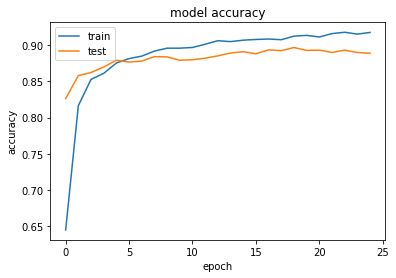

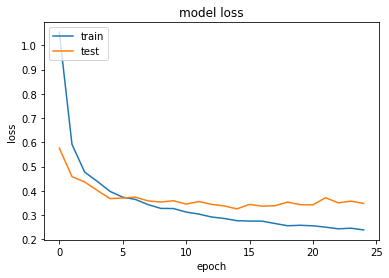

13887/13887 [==============================] - 197s 14ms/sample
[[4946    0    7    0    0    7    7   11]
 [   5  489    0    0    0    6    0    2]
 [  19    0 1147    0    0   14    4   12]
 [   6    9    3  689    0   25   11   77]
 [   0    0    1   72    3    9    4   11]
 [  13    0    3   64    0 4198    8    3]
 [   1    0    2    4    0   22  457   29]
 [  16   22   34  229    0   45  239  902]]
FOLD:  3
2777 11110
warppers is []
Train on 11110 samples, validate on 2777 samples
Epoch 1/100
11110/11110 [==============================] - 128s 11ms/sample - loss: 1.0882 - acc: 0.6252 - val_loss: 0.5153 - val_acc: 0.8498
Epoch 2/100
11110/11110 [==============================] - 54s 5ms/sample - loss: 0.5876 - acc: 0.8163 - val_loss: 0.4277 - val_acc: 0.8664
Epoch 3/100
11110/11110 [==============================] - 54s 5ms/sample - loss: 0.4930 - acc: 0.8467 - val_loss: 0.4178 - val_acc: 0.8725
Epoch 4/100
11110/11110 [==============================] - 54s 5ms/sample - loss: 0.4

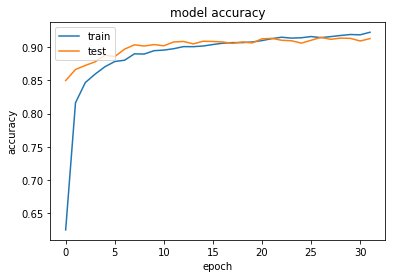

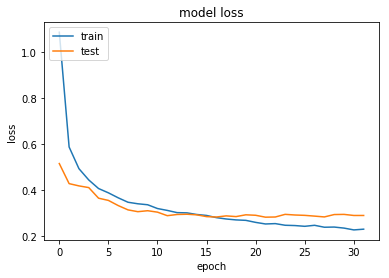

13887/13887 [==============================] - 195s 14ms/sample
[[4956    0   12    0    0    5    2    3]
 [   3  493    0    0    0    5    0    1]
 [  13    0 1154    0    0   11    0   18]
 [   3    9    3  670    1   19    7  108]
 [   2    0    0   65   13    4    2   14]
 [  12    0    0   67    0 4187   11   12]
 [   4    0    3    4    0    8  427   69]
 [  23   24   27  173    0   21   71 1148]]
FOLD:  4
2776 11111
warppers is []
Train on 11111 samples, validate on 2776 samples
Epoch 1/100
11111/11111 [==============================] - 128s 12ms/sample - loss: 1.1048 - acc: 0.6216 - val_loss: 0.5943 - val_acc: 0.8260
Epoch 2/100
11111/11111 [==============================] - 54s 5ms/sample - loss: 0.5776 - acc: 0.8176 - val_loss: 0.4857 - val_acc: 0.8566
Epoch 3/100
11111/11111 [==============================] - 54s 5ms/sample - loss: 0.4854 - acc: 0.8490 - val_loss: 0.4263 - val_acc: 0.8721
Epoch 4/100
11111/11111 [==============================] - 54s 5ms/sample - loss: 0.4

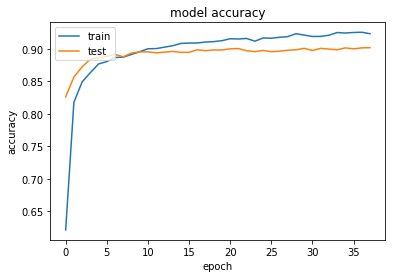

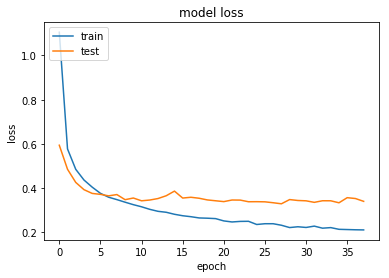

13887/13887 [==============================] - 201s 14ms/sample
[[4948    1    5    0    0    8    1   15]
 [   8  485    2    0    0    6    0    1]
 [  14    0 1160    0    0    8    0   14]
 [   4    9    4  660    4   21    6  112]
 [   0    0    1   62   18    4    2   13]
 [   9    0    6   59    1 4196    3   15]
 [   2    0    2    8    0   12  409   82]
 [  16   24   29  159    4   19   39 1197]]
FOLD:  5
2775 11112
warppers is []
Train on 11112 samples, validate on 2775 samples
Epoch 1/100
11112/11112 [==============================] - 128s 12ms/sample - loss: 1.0888 - acc: 0.6182 - val_loss: 0.5863 - val_acc: 0.8150
Epoch 2/100
11112/11112 [==============================] - 54s 5ms/sample - loss: 0.5927 - acc: 0.8154 - val_loss: 0.5002 - val_acc: 0.8493
Epoch 3/100
11112/11112 [==============================] - 53s 5ms/sample - loss: 0.4867 - acc: 0.8485 - val_loss: 0.4624 - val_acc: 0.8634
Epoch 4/100
11112/11112 [==============================] - 54s 5ms/sample - loss: 0.4

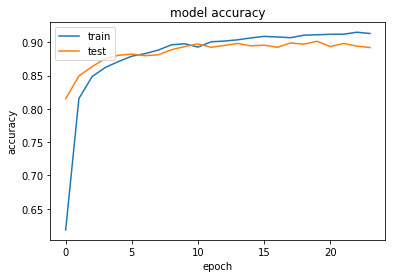

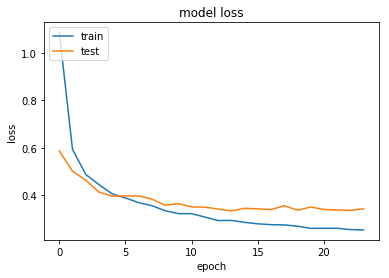

13887/13887 [==============================] - 195s 14ms/sample
[[4948    0    4    0    0    6    2   18]
 [   4  489    0    0    0    6    0    3]
 [  17    0 1132    0    0   12    2   33]
 [   4    9    5  625    1   23    8  145]
 [   5    0    0   50    4    4    2   35]
 [  15    0    4   65    0 4178    8   19]
 [   6    0    2    1    0   15  409   82]
 [  18   24   21  158    1   32  109 1124]]


In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 24
kernel_size_short = [2, 4, 6, 8, 10, 12, 14]
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = TextCNN_add_pool(max_len,max_cnt,embed_size,num_filters,kernel_size_short,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=64,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=64, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=64, verbose=1)
    
    pred_train = cpu_model.predict(train_seq, batch_size=64, verbose=1)
    print(confusion_matrix(multi_train_labels, pred_train.argmax(1)))
    #print(confusion_matrix(binary_labels.argmax(1), pred_train.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

In [0]:
import pandas as pd

test_df = pd.DataFrame(meta_test)
test_df.columns = ['prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7']
test_df.index += 1 
test_df.index.name = 'file_id'

test_df.to_csv(os.path.join(data_folder_path, 'secruity_submit_keep_50000_elements_add_aver_pooling_.csv'))

In [0]:
#loss: 0.2334 - acc: 0.9200 - val_loss: 0.3535 - val_acc: 0.8919

混合meanpooling和maxpooling+add filter_size

In [0]:
def TextCNN_add_pool(max_len, max_cnt, embed_size,
            num_filters, kernel_size,
            conv_action,
            mask_zero):
    _input = Input(shape=(max_len,), dtype='int32')
    _embed = Embedding(max_cnt, embed_size, input_length=max_len, mask_zero=mask_zero)(_input)
    _embed = SpatialDropout1D(0.2)(_embed)
    warppers = []
    print('warppers is', warppers)
    
    for _kernel_size in kernel_size:
        conv1d = Conv1D(filters=num_filters, kernel_size=_kernel_size, activation=conv_action)(_embed)
        warppers.append(GlobalMaxPooling1D()(conv1d))
        warppers.append(GlobalAveragePooling1D()(conv1d))
                        
    fc = concatenate(warppers)
    fc = Dropout(0.5)(fc)
    #fc = BatchNormalization()(fc)
    fc = Dense(256, activation='relu')(fc)
    fc = Dropout(0.25)(fc)
    #fc = BatchNormalization()(fc) 
    preds = Dense(8, activation = 'softmax')(fc)
    
    model = Model(inputs=_input, outputs=preds)
    
    return model

FOLD:  1
2780 11107
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
warppers is []

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Train on 11107 samples, validate on 2780 samples
Epoch 1/100
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
11107/11107 [==============================] - 162s 15ms/sample - loss: 1.0271 - acc: 0.6490 - val_loss: 0.5192 - val_acc: 0.8361
Epoch 2/100
11107/11107 [==============================] - 69s 6ms/sample - loss: 0.5505 - acc: 0.8245 - val_loss: 0.4118 - val_acc: 0.8646
Epoch 3/100
11107/11107 [============

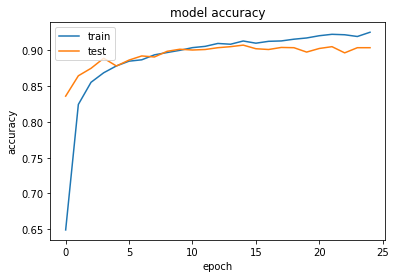

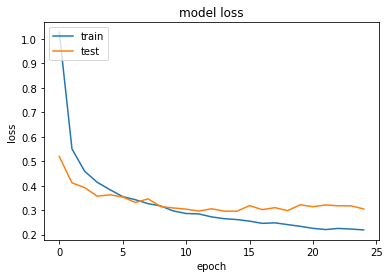

13887/13887 [==============================] - 375s 27ms/sample
[[4945    0   16    1    0    7    1    8]
 [   2  495    0    0    0    5    0    0]
 [  12    0 1170    0    0    8    0    6]
 [   1    9    4  719    5   25    2   55]
 [   0    0    1   55   28    8    1    7]
 [  12    0    4   68    1 4201    3    0]
 [   0    0    1    8    0   19  399   88]
 [  16   24   50  252   15   49   39 1042]]
FOLD:  2
2779 11108
warppers is []
Train on 11108 samples, validate on 2779 samples
Epoch 1/100
11108/11108 [==============================] - 177s 16ms/sample - loss: 1.0364 - acc: 0.6482 - val_loss: 0.5750 - val_acc: 0.8231
Epoch 2/100
11108/11108 [==============================] - 70s 6ms/sample - loss: 0.5491 - acc: 0.8311 - val_loss: 0.4462 - val_acc: 0.8591
Epoch 3/100
11108/11108 [==============================] - 69s 6ms/sample - loss: 0.4434 - acc: 0.8619 - val_loss: 0.4032 - val_acc: 0.8718
Epoch 4/100
11108/11108 [==============================] - 69s 6ms/sample - loss: 0.4

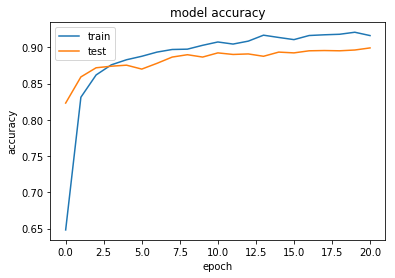

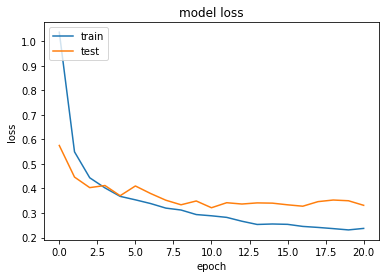

13887/13887 [==============================] - 371s 27ms/sample
[[4959    2    4    0    0    7    1    5]
 [   0  496    1    0    0    5    0    0]
 [  19    0 1162    0    0   10    0    5]
 [   8    9    5  699    3   26    7   63]
 [   1    0    1   59   24    6    2    7]
 [  13    0    1   68    0 4193    5    9]
 [   4    0    6    5    0   15  410   75]
 [  26   24   44  227   16   43   59 1048]]
FOLD:  3
2777 11110
warppers is []
Train on 11110 samples, validate on 2777 samples
Epoch 1/100
11110/11110 [==============================] - 181s 16ms/sample - loss: 1.0345 - acc: 0.6507 - val_loss: 0.5402 - val_acc: 0.8339
Epoch 2/100
11110/11110 [==============================] - 68s 6ms/sample - loss: 0.5703 - acc: 0.8181 - val_loss: 0.4289 - val_acc: 0.8761
Epoch 3/100
11110/11110 [==============================] - 69s 6ms/sample - loss: 0.4674 - acc: 0.8556 - val_loss: 0.3631 - val_acc: 0.8872
Epoch 4/100
11110/11110 [==============================] - 69s 6ms/sample - loss: 0.4

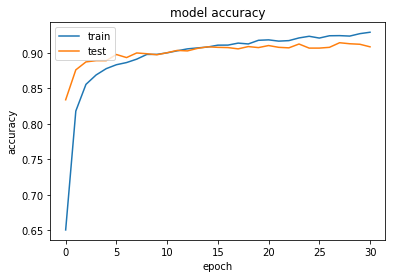

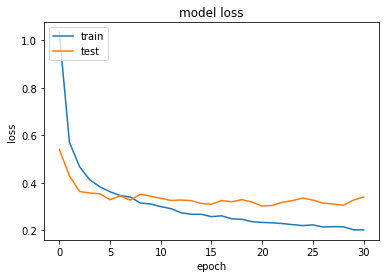

13887/13887 [==============================] - 381s 27ms/sample
[[4963    0    4    0    0    7    1    3]
 [   5  492    0    0    0    5    0    0]
 [  25    0 1152    0    0   11    0    8]
 [   5    9    2  605   30   24    8  137]
 [   2    0    0   19   63    4    1   11]
 [  11    0    0   62    2 4195    7   12]
 [   8    0    2    1    0    7  458   39]
 [  27   24   24  120   26   34   78 1154]]
FOLD:  4
2776 11111
warppers is []
Train on 11111 samples, validate on 2776 samples
Epoch 1/100
11111/11111 [==============================] - 172s 15ms/sample - loss: 1.0237 - acc: 0.6485 - val_loss: 0.5639 - val_acc: 0.8307
Epoch 2/100
11111/11111 [==============================] - 68s 6ms/sample - loss: 0.5518 - acc: 0.8279 - val_loss: 0.4480 - val_acc: 0.8653
Epoch 3/100
11111/11111 [==============================] - 68s 6ms/sample - loss: 0.4496 - acc: 0.8574 - val_loss: 0.4026 - val_acc: 0.8797
Epoch 4/100
11111/11111 [==============================] - 68s 6ms/sample - loss: 0.4

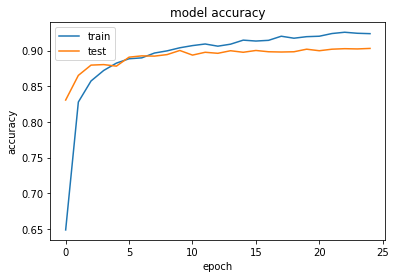

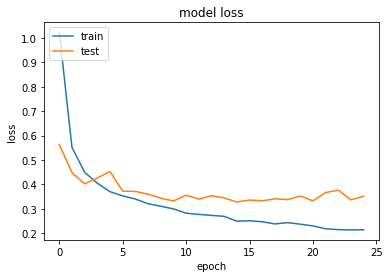

13887/13887 [==============================] - 372s 27ms/sample
[[4960    0    3    0    0    9    0    6]
 [   7  486    0    0    0    8    1    0]
 [  22    0 1151    4    0   12    0    7]
 [   4    9    4  677   12   21    8   85]
 [   0    0    0   45   40    6    2    7]
 [   6    0    1   56    1 4212    2   11]
 [   5    0    3    5    0   17  411   74]
 [  24   24   28  172   28   30   48 1133]]
FOLD:  5
2775 11112
warppers is []
Train on 11112 samples, validate on 2775 samples
Epoch 1/100
11112/11112 [==============================] - 170s 15ms/sample - loss: 1.0302 - acc: 0.6484 - val_loss: 0.5452 - val_acc: 0.8313
Epoch 2/100
11112/11112 [==============================] - 68s 6ms/sample - loss: 0.5646 - acc: 0.8285 - val_loss: 0.4204 - val_acc: 0.8663
Epoch 3/100
11112/11112 [==============================] - 68s 6ms/sample - loss: 0.4658 - acc: 0.8561 - val_loss: 0.4119 - val_acc: 0.8739
Epoch 4/100
11112/11112 [==============================] - 68s 6ms/sample - loss: 0.4

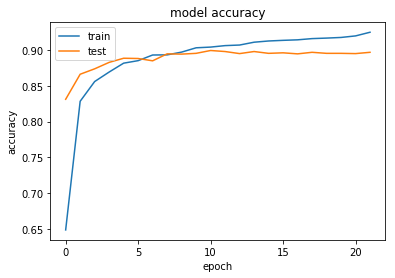

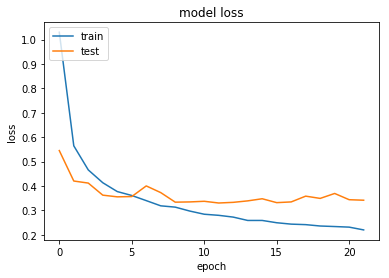

13887/13887 [==============================] - 380s 27ms/sample
[[4952    0    4    0    0    5    0   17]
 [   4  492    0    0    0    5    0    1]
 [  14    0 1162    0    0    9    1   10]
 [   2    9    5  563   17   23   13  188]
 [   3    0    2   11   47    5    2   30]
 [  13    0    6   58    1 4167   26   18]
 [   4    0    2    1    0    3  459   46]
 [  13   24   44  110   12   26  128 1130]]


In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 24
kernel_size_short = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = TextCNN_add_pool(max_len,max_cnt,embed_size,num_filters,kernel_size_short,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=64,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=64, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=64, verbose=1)
    
    pred_train = cpu_model.predict(train_seq, batch_size=64, verbose=1)
    print(confusion_matrix(multi_train_labels, pred_train.argmax(1)))
    #print(confusion_matrix(binary_labels.argmax(1), pred_train.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

In [0]:
import pandas as pd

test_df = pd.DataFrame(meta_test)
test_df.columns = ['prob0', 'prob1', 'prob2', 'prob3', 'prob4', 'prob5', 'prob6', 'prob7']
test_df.index += 1 
test_df.index.name = 'file_id'

test_df.to_csv(os.path.join(data_folder_path, 'secruity_submit_keep_50000_elements_add_aver_pooling_long_filters.csv'))

In [0]:
def TextCNN_add_pool(max_len, max_cnt, embed_size,
            num_filters, kernel_size,
            conv_action,
            mask_zero):
    _input = Input(shape=(max_len,), dtype='int32')
    _embed = Embedding(max_cnt, embed_size, input_length=max_len, mask_zero=mask_zero)(_input)
    _embed = SpatialDropout1D(0.2)(_embed)
    warppers = []
    print('warppers is', warppers)
    
    for _kernel_size in kernel_size:
        conv1d = Conv1D(filters=num_filters, kernel_size=_kernel_size, activation=conv_action)(_embed)
        warppers.append(GlobalMaxPooling1D()(conv1d))
        warppers.append(GlobalAveragePooling1D()(conv1d))
#         warppers.append(GlobalMaxPooling1D()(conv1d))
                        
    fc = concatenate(warppers)
    fc = Dropout(0.5)(fc)
    #fc = BatchNormalization()(fc)
    fc = Dense(256, activation='relu')(fc)
    fc = Dropout(0.25)(fc)
    #fc = BatchNormalization()(fc) 
    preds = Dense(8, activation = 'softmax')(fc)
    
    model = Model(inputs=_input, outputs=preds)
    
    return model

In [0]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
max_len = 50000
max_cnt = 302
embed_size = 128
num_filters = 24
kernel_size_short = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
conv_action = 'relu'
mask_zero = False
TRAIN = True


tf.logging.set_verbosity(0)

meta_train = np.zeros(shape = (len(train_seq), 8))
meta_test = np.zeros(shape = (len(test_seq), 8))

multi_train_labels = [np.argmax(i) for i in train_labels]
split_data = skf.split(train_seq, multi_train_labels)

for i,(tr_ind,te_ind) in enumerate(split_data):
    print('FOLD: ', i + 1)
    print(len(te_ind),len(tr_ind))
    model = TextCNN_add_pool(max_len,max_cnt,embed_size,num_filters,kernel_size_short,conv_action,mask_zero)
    model_name = 'benchmark_cnn_fold_' + str(i)
    X_train, X_train_label = train_seq[tr_ind], train_labels[tr_ind]
    X_val, X_val_label = train_seq[te_ind], train_labels[te_ind]
    model_save_path = '%s_%s.ckpt'%(model_name, embed_size)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, save_weights_only=True)

    strategy = tf.contrib.tpu.TPUDistributionStrategy(
        tf.contrib.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR']))
    model = tf.contrib.tpu.keras_to_tpu_model(model, strategy)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    if TRAIN:
        history = model.fit(X_train, X_train_label,
                  validation_data=(X_val, X_val_label),
                  epochs=100, batch_size=1,
                  shuffle=True,
                  callbacks=[early_stopping]
                 )
        
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    
    #model.load_weights(model_save_path)
    #model.save_weights('/tmp/%s.h5' % model_name, overwrite=True)
    cpu_model = model.sync_to_cpu()
    pred_val = cpu_model.predict(X_val, batch_size=1, verbose=1)
    pred_test = cpu_model.predict(test_seq, batch_size=1, verbose=1)
    pred_train = cpu_model.predict(X_train, batch_size=1, verbose=1)
    
    print('train confuse matrix is')
    print(confusion_matrix(X_train_label.argmax(1), pred_train.argmax(1)))
    print('val confuse matrix is')
    print(confusion_matrix(X_val_label.argmax(1), pred_val.argmax(1)))
    #print(confusion_matrix(binary_labels.argmax(1), pred_train.argmax(1)))
        
    meta_train[te_ind] = pred_val
    meta_test += pred_test
    tf.keras.backend.clear_session()
meta_test /= 5.0

FOLD:  1
2780 11107
warppers is []
Train on 11107 samples, validate on 2780 samples
Epoch 1/100


ValueError: ignored